<a href="https://colab.research.google.com/github/ameni-ayedi/GarbageClassifier/blob/main/GarbageClassifier_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

MessageError: ignored

In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import cv2
from tensorflow.keras import layers , models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from sklearn.model_selection import train_test_split ,cross_val_score
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import itertools
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix

In [ ]:
datadir="/content/drive/MyDrive/garbage_classification"

ParserError: ignored

In [ ]:
classes=['battery','biological','brown-glass','cardboard','clothes','green-glass','paper','plastic','shoes','trash','white-glass' ]

In [ ]:
import os
import shutil
import random

# Set the paths for the dataset
dataset_path = '/content/resized'
train_path = '/content/training_set'
test_path = '/content/testing_set'

# Create directories for training and testing sets
os.makedirs(dataset_path , exist_ok=True)
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)


In [ ]:
img_size=250
output_dir = '/content/resized' # specify the directory to save the resized images
for category in classes:
    path=os.path.join(datadir, category) # path to our the different type of trash
    for img in os.listdir(path):
          img_array = cv2.imread (os.path.join(path, img))
          img_array= cv2.resize(img_array, (img_size, img_size))
          output_path = os.path.join(output_dir, category, img) # specify the output path for the resized image
          os.makedirs(os.path.dirname(output_path), exist_ok=True) # create the output directory if it doesn't exist
          cv2.imwrite(output_path, img_array) # save the resized image to the output directory


In [ ]:
from PIL import Image

def load_image(image_path):
    with Image.open(image_path) as img:
        return np.array(img)

def save_image(image, save_path):
    with Image.fromarray(image) as img:
        img.save(save_path)

import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator

# Define the directory containing the images
train_dir = '/content/resized'

# Define the number of desired images for each class
num_desired_images = 4000

# Define the augmentation parameters
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

# Loop through each class
for class_name in os.listdir(train_dir):
    
    # Define the class directory and the number of images in the class
    class_dir = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_dir))
    
    # If the class is a minority class, generate new images
    if num_images < num_desired_images:
        
        # Compute the number of images to generate
        num_to_generate = num_desired_images - num_images
        
        # Load the existing images in the class
        images = []
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = load_image(image_path)
            images.append(image)
        
        # Generate new images using data augmentation
        i = 0
        for batch in datagen.flow(np.array(images), batch_size=1):
            image = batch[0].astype('uint8')
            save_image(image, os.path.join(class_dir, f'augmented_{i}.jpg'))
            i += 1
            if i == num_to_generate:
                break

In [ ]:
import os
import shutil
import random

# Set the paths for the dataset
dataset_path = '/content/resized'
train_path = '/content/training_set'
test_path = '/content/testing_set'

# Create directories for training and testing sets
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the ratio for splitting the datasetS
train_ratio = 0.8  # 80% for training, 20% for testing

# Loop through each class in the dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    # Create subdirectories in the training and testing sets
    train_class_path = os.path.join(train_path, class_name)
    test_class_path = os.path.join(test_path, class_name)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # Get the list of image files for this class
    image_files = os.listdir(class_path)

    # Shuffle the image files randomly
    random.shuffle(image_files)

    # Split the image files into training and testing sets
    split_index = int(len(image_files) * train_ratio)
    train_images = image_files[:split_index]
    test_images = image_files[split_index:]

    # Copy the training images to the training set directory
    for image_name in train_images:
        src_path = os.path.join(class_path, image_name)
        dst_path = os.path.join(train_class_path, image_name)
        shutil.copyfile(src_path, dst_path)

    # Copy the testing images to the testing set directory
    for image_name in test_images:
        src_path = os.path.join(class_path, image_name)
        dst_path = os.path.join(test_class_path, image_name)
        shutil.copyfile(src_path, dst_path)

print("Dataset split completed!")

Dataset split completed!


In [ ]:
train_path = '/content/training_set'
test_path = '/content/testing_set'

In [ ]:
input_shape = (300, 300, 3)
batch_size = 128 #128 is the optimal value
epochs = 40 

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
# Load the training dataset from the directory
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 36260 images belonging to 11 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the testing dataset from the directory
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=input_shape[:2],
    batch_size=batch_size,
    
    class_mode='categorical'
)

Found 9065 images belonging to 11 classes.


In [ ]:
from tensorflow.keras import regularizers

# Define the regularization strength
l2_reg = 0.001

# Define the model
waste_model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

In [ ]:
#epochs tunning using EarlyStopping
early_stopping_monitor=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    verbose=1,
    mode="min",restore_best_weights=True
)

In [ ]:
waste_model.compile(keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
waste_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 128)      0

In [ ]:
#Train the CNN model on the training dataset
history = waste_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping_monitor]
)
 
print("CNN model training completed!")

Epoch 1/40
284/284 [==============================] - 849s 3s/step - loss: 2.2226 - accuracy: 0.4118 - val_loss: 1.6180 - val_accuracy: 0.5755
Epoch 2/40
284/284 [==============================] - 823s 3s/step - loss: 1.7313 - accuracy: 0.5330 - val_loss: 1.5445 - val_accuracy: 0.5955
Epoch 3/40
284/284 [==============================] - 817s 3s/step - loss: 1.6136 - accuracy: 0.5699 - val_loss: 1.4807 - val_accuracy: 0.6152
Epoch 4/40
284/284 [==============================] - 815s 3s/step - loss: 1.5369 - accuracy: 0.5950 - val_loss: 1.3707 - val_accuracy: 0.6482
Epoch 5/40
284/284 [==============================] - 831s 3s/step - loss: 1.4892 - accuracy: 0.6067 - val_loss: 1.3851 - val_accuracy: 0.6350
Epoch 6/40
284/284 [==============================] - 821s 3s/step - loss: 1.4499 - accuracy: 0.6202 - val_loss: 1.3452 - val_accuracy: 0.6606
Epoch 7/40
284/284 [==============================] - 806s 3s/step - loss: 1.4345 - accuracy: 0.6305 - val_loss: 1.2789 - val_accuracy: 0.6837

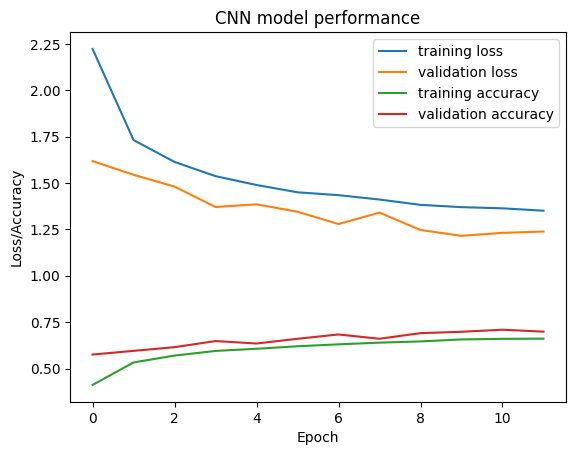

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('CNN model performance')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

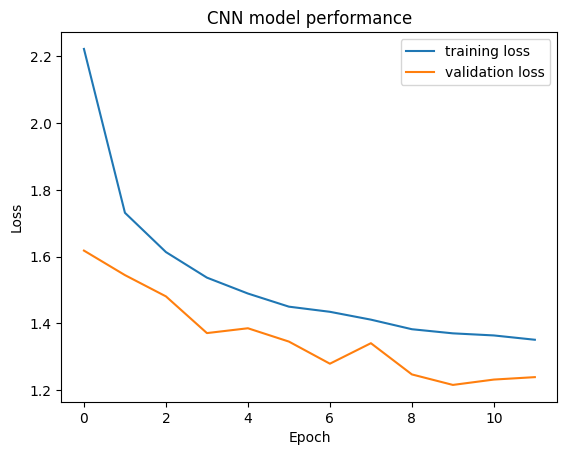

In [ ]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('CNN model performance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

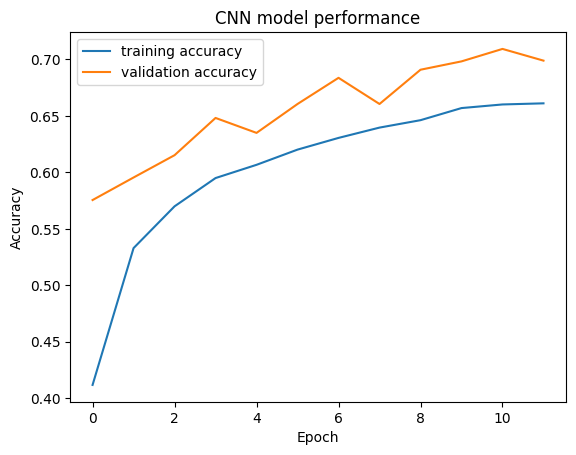

In [ ]:

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('CNN model performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
waste_model.save('waste_model_final.h5')


In [ ]:
from keras.models import load_model
model = load_model('/content/waste_model_final.h5')


In [ ]:
# Load and preprocess the input image
img_path = '/content/p.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (300, 300))
img = img / 255.0 # Normalize pixel values

# Make a prediction on the input image
preds =model.predict(np.expand_dims(img, axis=0))

# Get the predicted class index
class_index = np.argmax(preds)

# Get the predicted class name
class_name = classes[class_index]

# Print the predicted class name and probability
print(f"Predicted class: {class_name}")
print(f"Probability: {preds[0][class_index]:.2f}")

# Display the input image with the predicted class label
plt.imshow(img)
plt.title(class_name)
plt.show()


error: ignored

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
# Generate predictions for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_classes, y_pred_classes)

# Create plot
fig, ax = plt.subplots(figsize=(17,17))
im = ax.imshow(cm, cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Add labels, title, and ticks
ax.set_xlabel('Predicted labels', fontsize=17)
ax.set_ylabel('True labels', fontsize=17)
ax.set_title('Confusion Matrix', fontsize=17)
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_xticklabels(class_labels, rotation=45, fontsize=17)
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_yticklabels(class_labels, fontsize=17)

# Add values to the cells
thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=14)

plt.show()

# Création d'un rapport d'évaluation
print("Rapport d'évaluation : \n")
print(classification_report(true_classes, y_pred_classes, target_names=class_labels))